In [2]:
import pandas as pd; import numpy as np; import matplotlib as mtpl; import matplotlib.pyplot as plt;import time;import timeit
font = {'family' : 'serif',
        'weight' : 'ultralight',
        'size'   : 14}

mtpl.rc('font', **font)

In [3]:
import pandas as pd; import numpy as np; import matplotlib as mtpl; import matplotlib.pyplot as plt;import time;import timeit

dust_file='Dust records corregidos Completo.xlsx'
#dust_file='Dust records corregidos Completo Uniformes.xlsx'
#dust_file='EDC_DustFlux_25yr.xlsx'
id_columns=['Name','Data id','Latitud','Longitud','Age units','Data units','Data length']
id_data=pd.read_excel(dust_file,sheet_name=0,usecols=id_columns)
df_data=pd.read_excel(dust_file,sheet_name=1,skiprows=1)#skip row 1 o 0

#SEPARAR COLUMNAS
columns=df_data.size/len(df_data) ;lis=[];new_length=np.array([])

for i in range(int(columns)):
    if (i+1)%2==1: 
        dupla=df_data[[df_data.columns[i],df_data.columns[i+1]]].dropna() 
        dupla.index=[j for j in range(0, len(dupla))] 
        lis.append(dupla)
        new_length=np.append(new_length,np.shape(dupla)[0])
id_data

,Name,Data id,Latitud,Longitud,Age units,Data units,Data length
0,Vostok,1,-78.464167,106.865833,ka,(ug/m2/a),507
1,EPICA Dome C,2,-75.100000,123.350000,ka,(mg/m**2/a),298205
2,EPICA EDML,3,-75.002500,0.068400,ka,(ug/m**2/a),2303
3,Talos Dome,4,-72.817000,159.183000,ka BP,(µg/kg),64998
4,PS75/59-2,5,-54.215000,-125.425500,(kyr),(wt-%),2384
5,ML1208-17PC,6,0.480000,-156.450000,ka,(g/m2/yr),192
6,ML1208-31BB,7,4.680000,-160.050000,ka,(g/m2/yr),254
7,ML1208-37BB,8,7.040000,-161.630000,ka,(g/m2/yr),105
8,Xifeng,9,35.700000,107.600000,ka,(g/m^2/ka),722
9,Chinese Loess Plateau,10,35.760000,107.817333,ka,(g/cm3/ka),1801


In [87]:
def Smooth121(x):
    signal = x
    length = len(signal)
    output = np.zeros(length-2)
    coef= np.array([1,2,1])
    for i in range(length - 2):
        output[i]= np.sum(signal[i:i+3] * coef / 4)
    return output

def Haar(t,x,plot=False,smooth=False,bins=20):
    x=np.array(x);t=np.array(t)    
    #Cálculo deltas
    deltas_t=[];epsilons=[]
    for i in range(1,int(len(t)/2)+1):  #steps: i from 1 to n/2 
        deltas_t.append(t[i:]-t[:-i]) #0= Delta_t1, 1= Delta_t2, ..., [n/2]-1 = Delta_tn/2
    for i in range(1,len(deltas_t)+1): #for all my deltas_t (all steps-differences, de 1 en 1, de 2 en 2, etc)
        epsilons.append(deltas_t[i-1][:-i]/(deltas_t[i-1][:-i]+deltas_t[i-1][i:]))
    x=x[:-1];t=t[:-1]
    print('t samples:',len(t))
    print('deltas_t steps: from 1 to',len(deltas_t))
    print('epsilons steps:',len(epsilons))

    #Cálculo fluctuaciones
    Hs=[]; delta_t=[]; ep_min=0.25; ep_max=1-ep_min; calib=2; counter=0
    for H in range(2,len(x)-1,2):
        for start in range(len(x)-H-1):
            int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])
            int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
            counter+=1
            if ep_min<epsilons[int(H/2)-1][start] and epsilons[int(H/2)-1][start]<ep_max:
                #Hs.append(calib*abs(int2-int1)) #S_1
                Hs.append((calib*(int2-int1))**2) #S_2 (falta despues sacar raíz)
                delta_t.append(deltas_t[int(H/2)-1][start]+deltas_t[int(H/2)-1][start+int(H/2)]) #No logaritmicos           

    print(counter-len(Hs),' fluctuaciones eliminadas (',(counter-len(Hs))/counter*100,'%)')
    
    #Paso a dataframes
    data_df=pd.DataFrame(data={'delta t':delta_t , 'Hs': Hs}); data_sorted=data_df.sort_values('delta t',axis=0).reset_index(drop=True)

    #plt.subplots(figsize=(15, 7))
    #plt.title(' Scatter Haar fluctuation',fontsize=20);plt.xlabel('Log\u2081\u2080\u0394 t (Ky)',fontsize=18);plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)^1/2',fontsize=18)
    #plt.plot(data_df['delta t'],np.sqrt(data_df['Hs']),'.');plt.show()

    max_t=max(np.log10(data_sorted['delta t'])); min_t=min(np.log10(data_sorted['delta t']))
    n_bins=int(((max_t)-(min_t))*bins); rango_int=(max_t-min_t)/n_bins; time=np.array([]); ave_values=np.array([]); upper=np.array([]); lower=np.array([]);
    for i in range(n_bins):
        interval=data_sorted[(i*rango_int+min_t<=np.log10(data_sorted['delta t']))&(np.log10(data_sorted['delta t'])<min_t+(i+1)*rango_int)]
        time=np.append(time,((i*rango_int+min_t)+((i+1)*rango_int+min_t))/2)
        ave_values=np.append(ave_values,np.sqrt(interval.mean()[1]))        ## Tomo el sqrt del <[2*(x1-x2)]^2> ...
        upper=np.append(upper,np.sqrt(interval.mean()[1]+interval.std()[1]/np.sqrt(len(interval))))
        lower=np.append(lower,np.sqrt(interval.mean()[1]-interval.std()[1]/np.sqrt(len(interval))))
        
    if smooth==False:
        smooth_val=ave_values
    if smooth==True:
        smooth_val=Smooth121(ave_values)
        upper=Smooth121(upper)
        lower=Smooth121(lower)
        time=time[1:-1]
    val_mask = np.isfinite(smooth_val)
    
    time=time[val_mask] #??
    smooth_val=smooth_val[val_mask] #??
    upper=upper[val_mask]
    lower=lower[val_mask]
    
    if plot==True:
        plt.subplots(figsize=(15, 7))
        plt.title(' Sin test Haar fluctuation',fontsize=20);plt.xlabel('Log\u2081\u2080\u0394 t (Ky)',fontsize=18);plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)^1/2',fontsize=18)
        for i in range(n_bins):
            plt.axvline(x = i*rango_int+min_t,linestyle='-.',linewidth=0.5)
        plt.plot(time,np.log10(smooth_val),'.-',color='black',linewidth=2,label='Log binning')
        plt.legend()
        plt.show()

    return data_sorted['delta t'],data_sorted['Hs'],time,smooth_val,upper,lower


In [36]:
ix=3 #talos dome
t=lis[ix][lis[ix].columns[0]]
T=lis[ix][lis[ix].columns[1]]

t samples: 2499
deltas_t steps: from 1 to 1250
epsilons steps: 1250
20922  fluctuaciones eliminadas ( 1.3422276282564514 %)


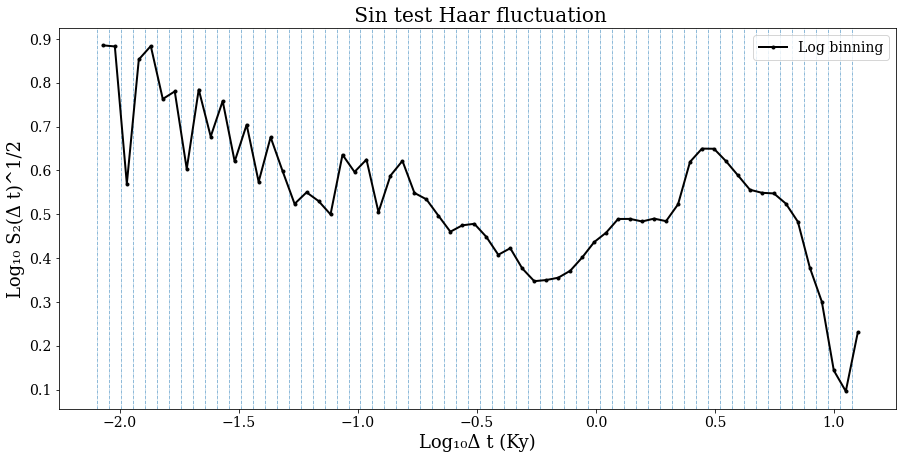

In [29]:
[delta_t,Hs,time,values,upper,lower]=Haar(t1,T1,smooth=False,plot=True)

In [109]:
t=lis[ix][lis[ix].columns[0]]
T=lis[ix][lis[ix].columns[1]]
tt=np.array([])
TT=np.array([])
for i in range(0,len(lis[ix][lis[ix].columns[0]]),20):
    tt=np.append(tt,t[i])
    TT=np.append(TT,T[i])

In [110]:
len(tt)

3031

In [49]:
t=lis[ix][lis[ix].columns[0]][:10000]
T=lis[ix][lis[ix].columns[1]][:10000]
t1=np.array([])
T1=np.array([])
for i in range(0,len(t),4):
    t1=np.append(t1,t[i])
    T1=np.append(T1,T[i])
print(len(t1))

t=lis[ix][lis[ix].columns[0]][10000:20000]
T=lis[ix][lis[ix].columns[1]][10000:20000]
t2=np.array([])
T2=np.array([])
for i in range(10000,20000,4):
    t2=np.append(t2,t[i])
    T2=np.append(T2,T[i])
print(len(t2))

t=lis[ix][lis[ix].columns[0]][20000:30000]
T=lis[ix][lis[ix].columns[1]][20000:30000]
t3=np.array([])
T3=np.array([])
for i in range(20000,30000,4):
    t3=np.append(t3,t[i])
    T3=np.append(T3,T[i])
print(len(t3))

t=lis[ix][lis[ix].columns[0]][30000:40000]
T=lis[ix][lis[ix].columns[1]][30000:40000]
t4=np.array([])
T4=np.array([])
for i in range(30000,40000,4):
    t4=np.append(t4,t[i])
    T4=np.append(T4,T[i])
print(len(t4))

t=lis[ix][lis[ix].columns[0]][40000:50000]
T=lis[ix][lis[ix].columns[1]][40000:50000]
t5=np.array([])
T5=np.array([])
for i in range(40000,50000,4):
    t5=np.append(t5,t[i])
    T5=np.append(T5,T[i])
print(len(t5))

t=lis[ix][lis[ix].columns[0]][50000:60000]
T=lis[ix][lis[ix].columns[1]][50000:60000]
t6=np.array([])
T6=np.array([])
for i in range(50000,60000,4):
    t6=np.append(t6,t[i])
    T6=np.append(T6,T[i])
print(len(t6))

2500
2500
2500
2500
2500
2500


t samples: 3030
deltas_t steps: from 1 to 1515
epsilons steps: 1515
177673  fluctuaciones eliminadas ( 7.7512132470347215 %)


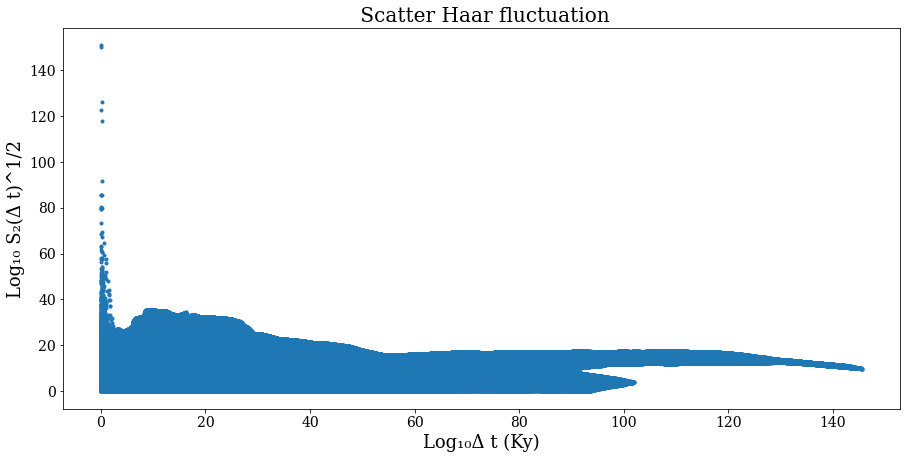

In [111]:
[delta_t,Hs,time,values,upper,lower]=Haar(tt,TT,smooth=True,plot=False,bins=20)
#[delta_t222,Hs222,time222,values222,upper222,lower222]=Haar(t2,T2,smooth=True,plot=False,bins=30)

In [51]:
[delta_t3,Hs3,time3,values3,upper3,lower3]=Haar(t3,T3,smooth=True,plot=False)
[delta_t4,Hs4,time4,values4,upper4,lower4]=Haar(t4,T4,smooth=True,plot=False)

t samples: 2499
deltas_t steps: from 1 to 1250
epsilons steps: 1250
1134  fluctuaciones eliminadas ( 0.07275050809878672 %)
t samples: 2499
deltas_t steps: from 1 to 1250
epsilons steps: 1250
1601  fluctuaciones eliminadas ( 0.10271037342694668 %)


In [52]:
[delta_t5,Hs5,time5,values5,upper5,lower5]=Haar(t5,T5,smooth=True,plot=False)
[delta_t6,Hs6,time6,values6,upper6,lower6]=Haar(t6,T6,smooth=True,plot=False)

t samples: 2499
deltas_t steps: from 1 to 1250
epsilons steps: 1250
1448  fluctuaciones eliminadas ( 0.0928948286834596 %)
t samples: 2499
deltas_t steps: from 1 to 1250
epsilons steps: 1250
106  fluctuaciones eliminadas ( 0.0068003120445074006 %)


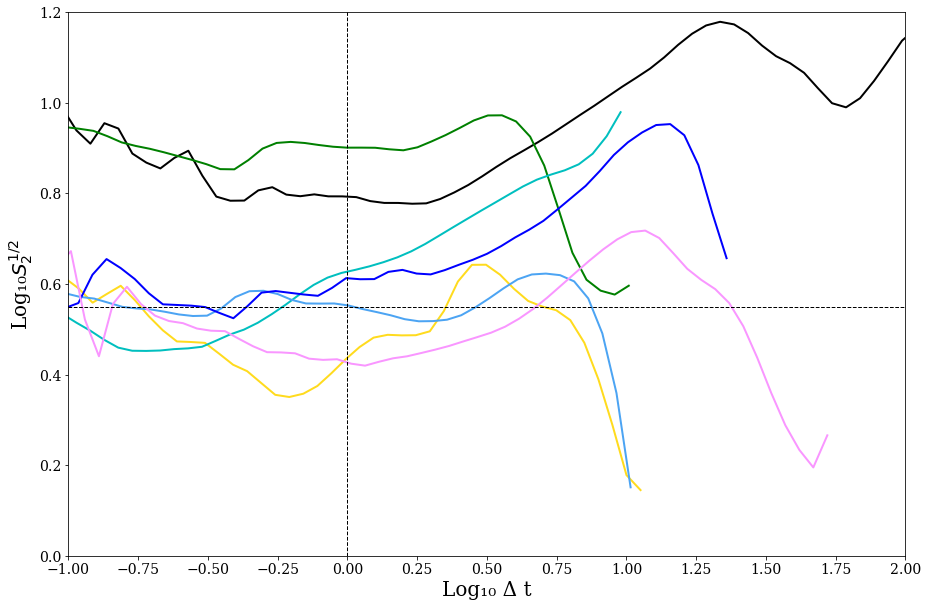

In [112]:
fig, (ax1) = plt.subplots(1,1,figsize=(15, 10))
#ax1.plot(time,np.log10(amp),'-',linewidth=2) ###############################################
ax1.plot(time,np.log10(values),'-',linewidth=2,color='black')
ax1.plot(time1,np.log10(values1),'-',linewidth=2,color='#ffdb1e')
ax1.plot(time2,np.log10(values2),'-',linewidth=2,color='g')
ax1.plot(time3,np.log10(values3),'-',linewidth=2,color='c')
ax1.plot(time4,np.log10(values4),'-',linewidth=2,color='#4ca4f3')
ax1.plot(time5,np.log10(values5),'-',linewidth=2,color='b')
ax1.plot(time6,np.log10(values6),'-',linewidth=2,color='#f996ff')

ax1.set_xticks([-1.75,-1.5,-1.25,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5])
ax1.set_xlabel('Log\u2081\u2080 \u0394 t', fontsize = 20.0)
ax1.set_ylabel('Log\u2081\u2080'+r'$S_2^{1/2}$', fontsize = 20.0)
#ax1.grid()
ax1.axhline(y=0.55,color='black',linewidth=1,linestyle='--')
ax1.axvline(x=0,color='black',linewidth=1,linestyle='--')
ax1.set(xlim=[-1,2])
ax1.set(ylim=[0,1.2])
plt.savefig('Talos.jpg',bbox_inches='tight')

plt.show()

C:\Users\javie\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


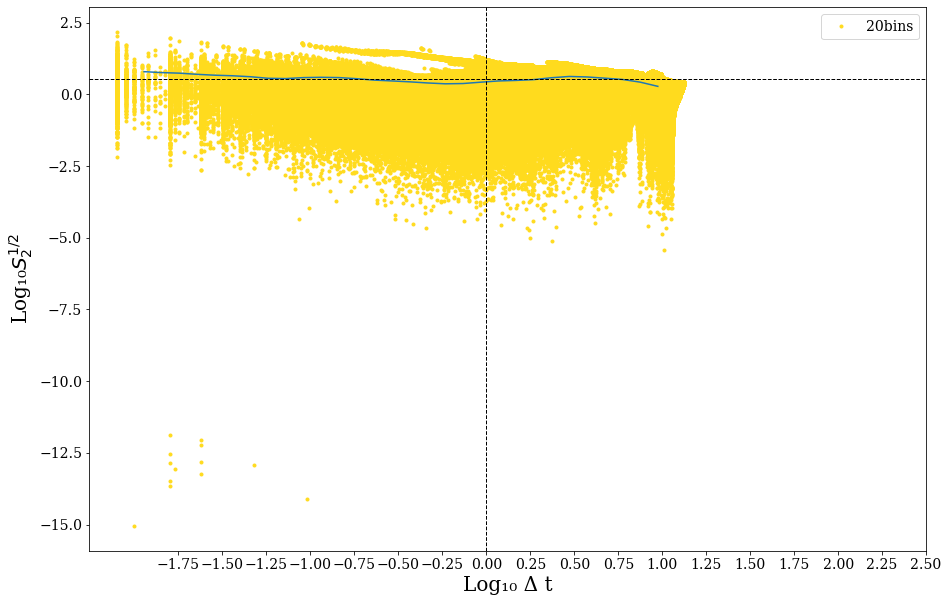

In [97]:
fig, (ax1) = plt.subplots(1,1,figsize=(15, 10))
ax1.plot(np.log10(delta_t11),np.log10(np.sqrt(Hs11)),'.',color='#ffdb1e',label='20bins')
ax1.plot(time11,np.log10(values11),'-')

ax1.set_xticks([-1.75,-1.5,-1.25,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5])
ax1.set_xlabel('Log\u2081\u2080 \u0394 t', fontsize = 20.0)
ax1.set_ylabel('Log\u2081\u2080'+r'$S_2^{1/2}$', fontsize = 20.0)
#ax1.grid()
ax1.axhline(y=0.55,color='black',linewidth=1,linestyle='--')
ax1.axvline(x=0,color='black',linewidth=1,linestyle='--')
#ax1.set(xlim=[-1,2])
#ax1.set(ylim=[0,1.2])
plt.legend()
plt.show()

In [84]:
len(delta_t1)

1537830

In [105]:
10**(-0.25)*1000

562.341325190349

In [94]:
[edml_uni_time,edml_uni_val]=Haar(2)
#[edml_time,edml_val]=[edml_uni_time,edml_uni_val].copy()

0  fluctuaciones eliminadas ( 0.0 %)


In [95]:
[ps75_uni_time,ps75_uni_val]=Haar(4)
#[ps75_time,ps75_val]=[ps75_uni_time,ps75_uni_val].copy()

0  fluctuaciones eliminadas ( 0.0 %)


In [96]:
[ml17pc_uni_time,ml17pc_uni_val]=Haar(5)
#[ml17pc_time,ml17pc_val]=[ml17pc_uni_time,ml17pc_uni_val].copy()

0  fluctuaciones eliminadas ( 0.0 %)


In [97]:
[ml31bb_uni_time,ml31bb_uni_val]=Haar(6)
#[ml31bb_time,ml31bb_val]=[ml31bb_uni_time,ml31bb_uni_val].copy()

0  fluctuaciones eliminadas ( 0.0 %)


In [98]:
[ml37bb_uni_time,ml37bb_uni_val]=Haar(7)
#[ml37bb_time,ml37bb_val]=[ml37bb_uni_time,ml37bb_uni_val].copy()

0  fluctuaciones eliminadas ( 0.0 %)


In [99]:
[xifeng_uni_time,xifeng_uni_val]=Haar(8)
#[xifeng_time,xifeng_val]=[xifeng_uni_time,xifeng_uni_val].copy()

0  fluctuaciones eliminadas ( 0.0 %)


In [100]:
[chinese_uni_time,chinese_uni_val]=Haar(9)
#[chinese_time,chinese_val]=[chinese_uni_time,chinese_uni_val].copy()

0  fluctuaciones eliminadas ( 0.0 %)


In [101]:
[recap_uni_time,recap_uni_val]=Haar(10)
#[recap_time,recap_val]=[recap_uni_time,recap_uni_val].copy()

0  fluctuaciones eliminadas ( 0.0 %)


In [102]:
[grip_uni_time,grip_uni_val]=Haar(11)
#[grip_time,grip_val]=[grip_uni_time,grip_uni_val].copy()

0  fluctuaciones eliminadas ( 0.0 %)


In [103]:
[ngrip_uni_time,ngrip_uni_val]=Haar(12)
#[ngrip_time,ngrip_val]=Haar(12)

0  fluctuaciones eliminadas ( 0.0 %)


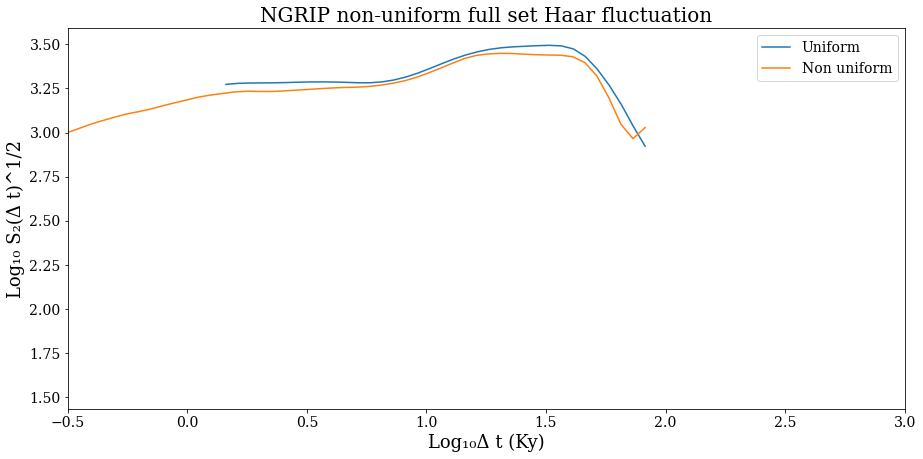

In [130]:
ix=12
plt.subplots(figsize=(15, 7))
plt.title(id_data['Name'][ix]+' non-uniform full set Haar fluctuation',fontsize=20);plt.xlabel('Log\u2081\u2080\u0394 t (Ky)',fontsize=18);plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)^1/2',fontsize=18)
plt.plot(ngrip_uni_time,ngrip_uni_val,'-',label='Uniform')
plt.plot(ngrip_time,ngrip_val,'-',label='Non uniform')
plt.xlim(-0.5,3)
plt.legend()

if ix==4:
    plt.savefig('1.0-PS7559-2 smooth-scatter.jpg',bbox_inches='tight')
else:
    plt.savefig(id_data['Name'][ix]+' uni - non uni comparison.jpg',bbox_inches='tight')
plt.show()


In [248]:
#Testeo EDC tomando menos puntos
ix=1
x=np.array(lis[ix][lis[ix].columns[1]]);t=np.array(lis[ix][lis[ix].columns[0]])
print(len(x),len(t))

short_edc_time=[]; short_edc_val=[]
for i in range(0,len(x),10):
    short_edc_time.append(t[i])
    short_edc_val.append(x[i])
print(len(short_edc_val),len(short_edc_time))

31838 31838
3184 3184


In [243]:
ix=3
x=np.array(lis[ix][lis[ix].columns[1]]);t=np.array(lis[ix][lis[ix].columns[0]])
print(len(x),len(t))

short_talos_time=[]; short_talos_val=[]
for i in range(0,len(x),10):
    short_talos_time.append(t[i])
    short_talos_val.append(x[i])
print(len(short_talos_val),len(short_talos_time))


60616 60616
6062 6062


t samples: 3184
deltas_t steps: from 1 to 1592
epsilons steps: 1592
0  fluctuaciones eliminadas
2529690


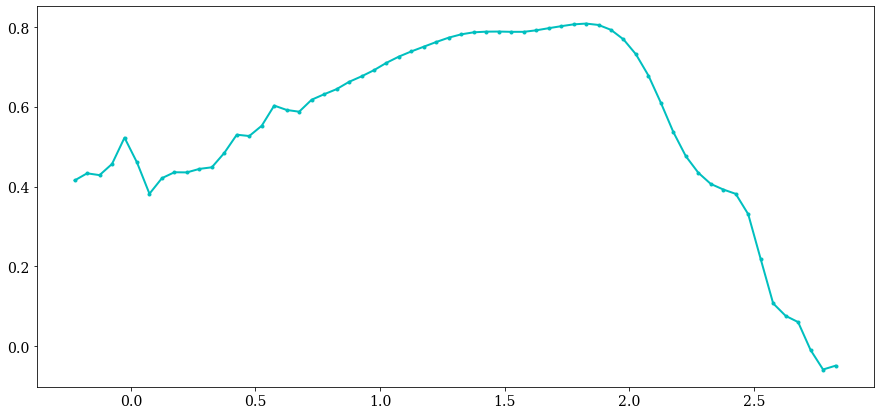

In [249]:
ix=1
#x=np.array(lis[ix][lis[ix].columns[1]])[40000:50000];t=np.array(lis[ix][lis[ix].columns[0]])[40000:50000]
x=np.array(short_edc_val);t=np.array(short_edc_time)
#x=np.array(short_talos_val);t=np.array(short_talos_time)

deltas_t=[]
for i in range(1,int(len(t)/2)+1):  #steps: i from 1 to n/2 
    deltas_t.append(t[i:]-t[:-i]) #0= Delta_t1, 1= Delta_t2, ..., [n/2]-1 = Delta_tn/2

epsilons=[]
for i in range(1,len(deltas_t)+1): #for all my deltas_t (all steps-differences, de 1 en 1, de 2 en 2, etc)
    epsilons.append(deltas_t[i-1][:-i]/(deltas_t[i-1][:-i]+deltas_t[i-1][i:]))
    
print('t samples:',len(t))
print('deltas_t steps: from 1 to',len(deltas_t))
print('epsilons steps:',len(epsilons))
x=x[:-1];t=t[:-1]

#############################################

Hs=[];delta_t=[];ep_min=0.25; ep_max=1-ep_min;calib=2; counter=0

for H in range(2,len(x)-1,2):
    for start in range(len(x)-H-1):
        int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])
        int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
        counter+=1
        if ep_min<epsilons[int(H/2)-1][start] and epsilons[int(H/2)-1][start]<ep_max:
            #Hs.append(calib*abs(int2-int1)) #S_1
            Hs.append((calib*(int2-int1))**2) #S_2 (falta despues sacar raíz)
            delta_t.append(deltas_t[int(H/2)-1][start]+deltas_t[int(H/2)-1][start+int(H/2)]) #No logaritmicos           
            
print(counter-len(Hs),' fluctuaciones eliminadas')
print(counter)

#############################################
data_df=pd.DataFrame(data={'delta t':delta_t , 'Hs': Hs}); 
data_sorted=data_df.sort_values('delta t',axis=0).reset_index(drop=True)

max_t=np.log10(max(data_sorted['delta t'])); min_t=np.log10(min(data_sorted['delta t']))
n_bins=int(((max_t)-(min_t))*20); rango_int2=(max_t-min_t)/n_bins

time2=[];ave_values2=[];upper=[];lower=[];

plt.subplots(figsize=(15, 7))
for i in range(n_bins):
    interval=data_sorted[(i*rango_int2+min_t<=np.log10(data_sorted['delta t']))&(np.log10(data_sorted['delta t'])<min_t+(i+1)*rango_int2)]
    time2.append(((i*rango_int2+min_t)+((i+1)*rango_int2+min_t))/2)
    #ave_values2.append(interval.mean()[1])  #S1
    ave_values2.append(np.sqrt(interval.mean()[1]))        ## Tomo el sqrt del <[2*(x1-x2)]^2> ...
smooth_val=Smooth121(ave_values2)

plt.plot(time2[1:-1],np.log10(smooth_val),'.-',color='c',linewidth=2,label=' Log binning')
plt.show()


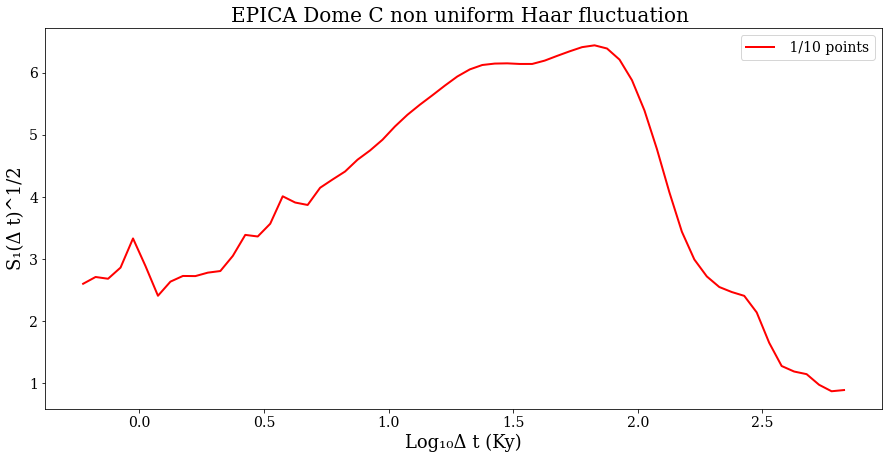

In [265]:
plt.subplots(figsize=(15, 7))
plt.plot(time2[1:-1],(smooth_val),'-',color='red',linewidth=2,label=' 1/10 points')
plt.title(id_data['Name'][ix]+' non uniform Haar fluctuation ',fontsize=20)
#plt.xlabel('Log\u2081\u2080\u0394 t (Ky)',fontsize=18);plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)^1/2',fontsize=18)
plt.xlabel('Log\u2081\u2080\u0394 t (Ky)',fontsize=18);plt.ylabel('S\u2081(\u0394 t)^1/2',fontsize=18)
#plt.axvline(x = 0,linestyle='-',color='black',linewidth=0.5)
#plt.axvline(x = 2,linestyle='-',color='black',linewidth=0.5)
#plt.axhline(y = 0,linestyle='-',color='black',linewidth=0.5)
plt.legend();#plt.xlim(-1,2)#;plt.ylim(0.8,5)
plt.savefig(' Validation test edc.jpg',bbox_inches='tight')
plt.show()

In [259]:
10**1

10

In [262]:
np.log10(100)

2.0

#### Pruebo sumar el reverso también

In [204]:
#REVERSOOO
ix=1
#x_rev=np.array(lis[ix][lis[ix].columns[1]])[::-1][:10000];t_rev=np.array(lis[ix][lis[ix].columns[0]])[::-1][:10000]
x_rev=np.array(short_edc_val)[::-1];t_rev=np.array(short_edc_time)[::-1]

deltas_t_rev=[]
for i in range(1,int(len(t_rev)/2)+1):  #steps: i from 1 to n/2 
    deltas_t_rev.append(t_rev[i:]-t_rev[:-i]) #0= Delta_t1, 1= Delta_t2, ..., [n/2]-1 = Delta_tn/2

epsilons_rev=[]
for i in range(1,len(deltas_t_rev)+1): #for all my deltas_t (all steps-differences, de 1 en 1, de 2 en 2, etc)
    epsilons_rev.append(deltas_t_rev[i-1][:-i]/(deltas_t_rev[i-1][:-i]+deltas_t_rev[i-1][i:]))
    
print('t samples:',len(t_rev))
print('deltas_t steps: from 1 to',len(deltas_t_rev))
print('epsilons steps:',len(epsilons_rev))
x_rev=x_rev[:-1];t_rev=t_rev[:-1]

Hs_rev=[];delta_t_rev=[];ep_min=0.25; ep_max=1-ep_min

for H in range(2,len(x_rev)-1,2):
    for start in range(len(x_rev)-H-1):
        int1_=np.sum(x_rev[start:start+int(H/2)]*deltas_t_rev[0][start:start+int(H/2)]/deltas_t_rev[int(H/2)-1][start])
        int2=np.sum(x_rev[start+int(H/2):start+H]*deltas_t_rev[0][start+int(H/2):start+H]/deltas_t_rev[int(H/2)-1][start+int(H/2)])
        
        if ep_min<epsilons_rev[int(H/2)-1][start] and epsilons_rev[int(H/2)-1][start]<ep_max:
            #Hs_rev.append(abs(int2-int1)) #S_1
            Hs_rev.append(calib*(int2-int1)**2) #S_2 (falta despues sacar raíz)
            delta_t_rev.append(deltas_t_rev[int(H/2)-1][start]+deltas_t_rev[int(H/2)-1][start+int(H/2)]) #No logaritmicos           
print(H)

t samples: 3184
deltas_t steps: from 1 to 1592
epsilons steps: 1592
3180


In [219]:
data_df_rev=pd.DataFrame(data={'delta t':abs(np.array(delta_t_rev)) , 'Hs': Hs_rev});##time in Kyears para comparar con shaun!!
data_sorted_rev=data_df_rev.sort_values('delta t',axis=0).reset_index(drop=True)
#data_sorted_rev

In [209]:
max_t=np.log10(max(data_sorted_rev['delta t'])); min_t=np.log10(min(data_sorted_rev['delta t']))
n_bins=int(((max_t)-(min_t))*20); rango_int2=(max_t-min_t)/n_bins

time_rev=[];ave_values_rev=[];upper_rev=[];lower_rev=[];

for i in range(n_bins):
    interval=data_sorted_rev[(i*rango_int2+min_t<=np.log10(data_sorted_rev['delta t']))&(np.log10(data_sorted_rev['delta t'])<min_t+(i+1)*rango_int2)]
    time_rev.append(((i*rango_int2+min_t)+((i+1)*rango_int2+min_t))/2)
    ave_values_rev.append(np.sqrt(interval.mean()[1]))        ## Tomo el sqrt del <[2*(x1-x2)]^2> ...
smooth_val_rev=Smooth121(ave_values_rev)

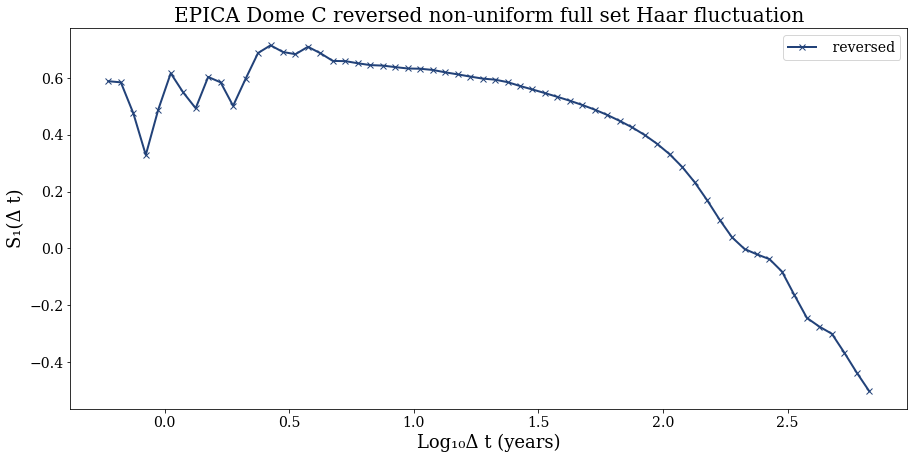

In [212]:
plt.subplots(figsize=(15, 7))
plt.plot(time_rev[1:-1],np.log10(smooth_val_rev),'x-',linewidth=2,color='#224279',label=' reversed')
plt.title(id_data['Name'][ix]+' reversed non-uniform full set Haar fluctuation',fontsize=20);plt.xlabel('Log\u2081\u2080\u0394 t (years)',fontsize=18);plt.ylabel('S\u2081(\u0394 t)',fontsize=18)
plt.legend();plt.show()

In [220]:
big_data = pd.concat([data_df,data_df_rev])
big_data_sorted=big_data.sort_values('delta t',axis=0).reset_index(drop=True)
#big_data_sorted

In [214]:
max_t=np.log10(max(big_data['delta t'])); min_t=np.log10(min(big_data['delta t']))
n_bins=int(((max_t)-(min_t))*20); rango_int2=(max_t-min_t)/n_bins

big_time=[];big_ave_values=[]

for i in range(n_bins):
    interval=big_data_sorted[(i*rango_int2+min_t<=np.log10(big_data_sorted['delta t']))&(np.log10(big_data_sorted['delta t'])<min_t+(i+1)*rango_int2)]
    big_time.append(((i*rango_int2+min_t)+((i+1)*rango_int2+min_t))/2)
    big_ave_values.append(np.sqrt(interval.mean()[1]))        ## Tomo el sqrt del <[2*(x1-x2)]^2> ...
big_smooth_val=Smooth121(big_ave_values)

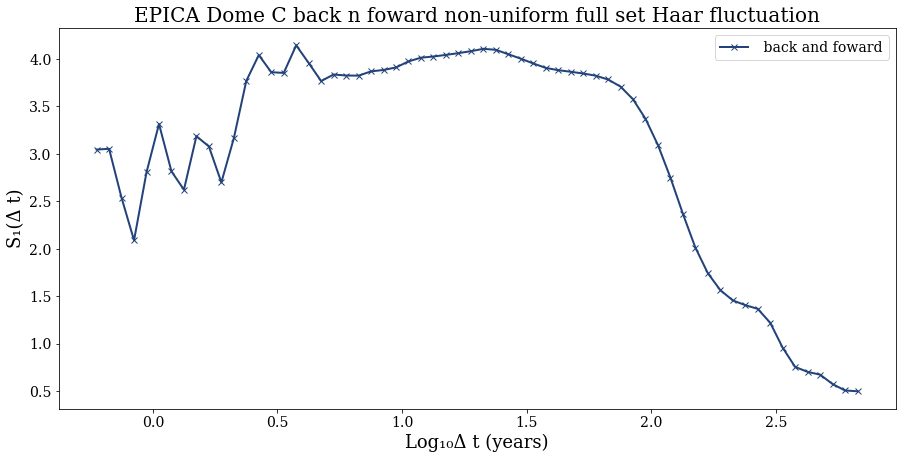

In [218]:
plt.subplots(figsize=(15, 7))
plt.plot(big_time[1:-1],(big_smooth_val),'x-',linewidth=2,color='#224279',label=' back and foward')
plt.title(id_data['Name'][ix]+' back n foward non-uniform full set Haar fluctuation',fontsize=20);plt.xlabel('Log\u2081\u2080\u0394 t (years)',fontsize=18);plt.ylabel('S\u2081(\u0394 t)',fontsize=18)
plt.legend();#plt.xlim(1.5,6);plt.ylim(750,1250)
plt.show()

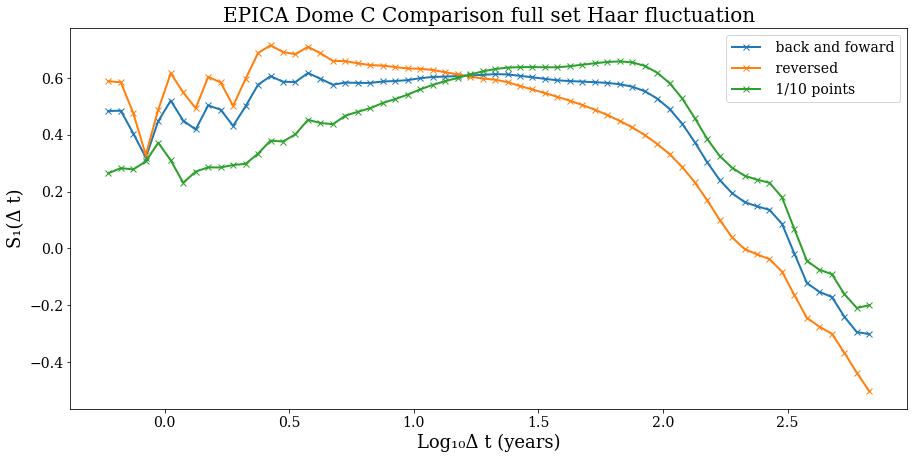

In [217]:
plt.subplots(figsize=(15, 7))
plt.plot(big_time[1:-1],np.log10(big_smooth_val),'x-',linewidth=2,label=' back and foward')
plt.plot(time_rev[1:-1],np.log10(smooth_val_rev),'x-',linewidth=2,label=' reversed')
plt.plot(time2[1:-1],np.log10(smooth_val),'x-',linewidth=2,label=' 1/10 points')


plt.title(id_data['Name'][ix]+' Comparison full set Haar fluctuation',fontsize=20);plt.xlabel('Log\u2081\u2080\u0394 t (years)',fontsize=18);plt.ylabel('S\u2081(\u0394 t)',fontsize=18)
plt.legend();#plt.xlim(1.5,6);plt.ylim(750,1250)
plt.show()